# Predicting Cassava Disease

#### Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoImageProcessor, AutoModel
from torchvision import transforms
import numpy as np
import csv
from PIL import Image
import os
from tqdm import tqdm
import time
import pandas as pd

In [5]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load the DINO model and processor
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
dinov2_model = AutoModel.from_pretrained("facebook/dinov2-large").to(device)

print("DINOv2 model loaded successfully!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

DINOv2 model loaded successfully!


#### Load Pre-computed Features

In [7]:
path_to_dino_features = "/content/drive/MyDrive/DATASCI 281 Final Project/Data/dino_features.csv"
_dino_feats_df = pd.read_csv(path_to_dino_features)
_dino_feats_df

,image_name,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,822187943.jpg,-1.048670,-0.923049,-1.202858,-0.196354,-0.841452,-0.168096,-1.669436,1.820413,1.066286,...,-1.605651,0.515198,-2.119278,0.184485,1.026142,1.069464,1.028244,-1.764543,0.617377,2.925795
1,832729024.jpg,-0.180364,-1.164014,-1.444266,-1.118974,2.749749,0.164368,-2.843360,-0.001612,0.540367,...,-0.661436,1.835895,1.363420,0.761786,-2.121486,-0.602252,0.029699,-1.909669,-0.059045,1.988318
2,828740814.jpg,0.705347,-2.085517,-0.874355,0.764672,2.821578,-1.348790,-2.234709,-1.117109,1.540348,...,-1.755436,2.285558,0.126890,0.024660,-2.062122,2.077018,0.940617,-1.984532,0.612511,2.838746
3,812733394.jpg,-1.797358,0.747194,-1.194025,-0.312248,1.349938,-0.743084,-0.510548,-0.426005,0.226023,...,-0.270528,1.033666,0.402389,0.939857,-0.667017,2.101953,-1.364544,-1.843017,-0.809529,2.516391
4,804506814.jpg,-1.252457,-1.067492,-1.311061,0.581470,2.030968,-2.172957,-1.581082,0.748559,-0.503183,...,0.653937,2.220270,0.676023,-0.768723,-0.517698,1.210865,0.183417,-1.126204,2.455718,2.316103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,1775105594.jpg,-0.749779,-1.646598,-0.989489,1.350402,3.589592,-1.250470,-1.095028,-0.207246,0.999513,...,-0.361496,0.466059,0.280578,0.014974,-1.270624,-0.556333,0.470838,-2.253877,0.953988,3.836547
17934,1765114818.jpg,-0.408827,-1.066258,-0.657114,0.678726,1.464072,-0.970098,-1.516017,0.605618,0.570991,...,0.241022,1.176970,0.857900,2.684915,-1.208870,1.925695,0.971109,-3.114256,1.593495,2.089472
17935,1786164172.jpg,0.323531,-1.426993,-1.291437,0.031251,2.160870,-0.346033,-2.156207,-0.159149,0.551207,...,-0.552023,0.994882,0.052517,0.331219,-1.192372,2.745811,0.347217,-2.479471,0.775450,2.900738
17936,1772421330.jpg,-0.694996,-1.899508,-2.620448,0.412439,2.696033,0.956773,-3.145855,0.644982,1.668711,...,-0.389531,1.963414,-0.780424,0.967423,-1.097903,3.791077,-0.459226,-2.327100,0.375559,2.028275


### Compute Additional Features - HOG, Color, Edge, Fourier

#### Pre-defined functions

In [11]:
import pandas as pd
import numpy as np
import json
from skimage import io, color, feature
from skimage.transform import resize
from skimage.feature import canny
from scipy.fft import fft2, fftshift
import multiprocessing
from multiprocessing import Pool

# Load existing DINOv2 features
existing_features = _dino_feats_df.copy()  # Assuming this dataframe is already defined
image_folder = "/content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images"
json_file_path = '/content/drive/MyDrive/DATASCI 281 Final Project/Data/label_num_to_disease_map.json'
existing_images_path = '/content/drive/MyDrive/DATASCI 281 Final Project/Data/existing_images.csv'

# Load label map from JSON file
with open(json_file_path, 'r') as json_file:
    label_map = json.load(json_file)

existing_images_df = pd.read_csv(existing_images_path)

existing_features= existing_features.merge(right=existing_images_df,
                                           how='left',
                                           left_on=['image_name'],
                                           right_on=['image_id'])

# Adding disease labels to DINOv2 features dataset
existing_features['disease_name'] = existing_features['label'].astype(str).map(label_map)

# Copy to balanced_images
balanced_images = existing_features.copy()

def process_image(image_name, image_folder):
    try:
        # Load and resize image
        image_path = f"{image_folder}/{image_name}"
        image = io.imread(image_path)
        print(f'Processing image: {image_path}')
        gray_image = color.rgb2gray(image)
        gray_image_resized = resize(gray_image, (224, 224), anti_aliasing=True)

        # Compute HOG features
        hog_feature = feature.hog(
            gray_image_resized,
            orientations=6,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            feature_vector=True
        )

        # Compute color histogram features
        color_hist_feature = np.histogram(image, bins=32, range=(0, 256), density=True)[0]

        # Color-based features: mean and std of RGB channels
        mean_rgb = np.mean(image, axis=(0, 1))  # Mean of R, G, B
        std_rgb = np.std(image, axis=(0, 1))    # Standard deviation of R, G, B

        # Canny edge feature
        canny_edges = canny(gray_image_resized)
        edge_density = np.sum(canny_edges) / canny_edges.size  # Proportion of edges in the image

        # Fourier Transform feature (magnitude spectrum)
        image_fft = fft2(gray_image_resized)
        image_fft_shifted = fftshift(image_fft)  # Shift zero frequency to the center
        magnitude_spectrum = np.abs(image_fft_shifted)
        fft_mean = np.mean(magnitude_spectrum)
        fft_std = np.std(magnitude_spectrum)

        print(f'Image processed: {image_path}')

        # Return computed features
        return (hog_feature, color_hist_feature, mean_rgb, std_rgb, edge_density, fft_mean, fft_std)

    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        return None

if __name__ == "__main__":
    # Set the start method for multiprocessing (for Colab compatibility)
    multiprocessing.set_start_method("fork", force=True)

    # Parallel processing using Pool
    with Pool(multiprocessing.cpu_count()) as pool:
        results = pool.starmap(process_image, [(image_name, image_folder) for image_name in balanced_images['image_name']])

    # Filter out None results
    valid_results = [r for r in results if r is not None]

    if valid_results:  # Ensure there are valid results
        # Unzip features into individual lists
        hog_features, color_hist_features, mean_rgb, std_rgb, edge_density, fft_mean, fft_std = zip(*valid_results)

        # Convert features to DataFrames
        hog_df = pd.DataFrame(hog_features, columns=[f'hog_{i}' for i in range(len(hog_features[0]))])
        color_hist_df = pd.DataFrame(color_hist_features, columns=[f'color_hist_{i}' for i in range(len(color_hist_features[0]))])

        # Additional feature DataFrames
        color_mean_df = pd.DataFrame(mean_rgb, columns=['mean_r', 'mean_g', 'mean_b'])
        color_std_df = pd.DataFrame(std_rgb, columns=['std_r', 'std_g', 'std_b'])
        edge_density_df = pd.DataFrame(edge_density, columns=['edge_density'])
        fft_mean_df = pd.DataFrame(fft_mean, columns=['fft_mean'])
        fft_std_df = pd.DataFrame(fft_std, columns=['fft_std'])

        # Concatenate all features with the original dataset
        balanced_images.reset_index(drop=True, inplace=True)
        combined_features = pd.concat([
            balanced_images,
            hog_df,
            color_hist_df,
            color_mean_df,
            color_std_df,
            edge_density_df,
            fft_mean_df,
            fft_std_df
        ], axis=1)

        # Save the processed dataset to a CSV file
        output_csv_path = "/content/combined_features_balanced.csv"
        combined_features.to_csv(output_csv_path, index=False)
        print(f"Saved combined features to {output_csv_path}")
    else:
        print("No valid results to process.")

Streaming output truncated to the last 5000 lines.
Processing image: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/2421584728.jpg
Image processed: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/2284607100.jpgProcessing image: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/2042895796.jpg

Image processed: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/1840620834.jpgProcessing image: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/1667611388.jpg

Image processed: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/2128581284.jpg
Image processed: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/2421584728.jpg
Processing image: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/1951284903.jpg
Image processed: /content/drive/MyDrive/DATASCI 281 Final Project/Data/train_images/2042895796.jpg
Image processed: /content/drive/MyDrive/DATASCI 281 Fi

In [12]:
from google.colab import files
files.download("/content/combined_features_balanced.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Check for label column (e.g., 'disease_name')
if 'disease_name' in combined_features.columns:
    # Count the number of images per label
    label_counts = combined_features['disease_name'].value_counts()
    print("Number of images per label:\n", label_counts)

Number of images per label:
 disease_name
Cassava Mosaic Disease (CMD)           11027
Healthy                                 2166
Cassava Green Mottle (CGM)              1993
Cassava Brown Streak Disease (CBSD)     1831
Cassava Bacterial Blight (CBB)           921
Name: count, dtype: int64


In [14]:
# display the shape of the data
print(f"Number of rows: {combined_features.shape[0]}, Number of columns: {combined_features.shape[1]}")

Number of rows: 17938, Number of columns: 5125


### Dimentionality Reduction Using Principle Component Analysis

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = combined_features.copy()

# Fit PCA to the data
pca = PCA()
pca.fit(data.drop(columns=['image_name', 'image_id', 'label', 'disease_name']))

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 95% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {num_components}")

Number of components for 95% variance: 130


Number of components for 95% variance: 1267


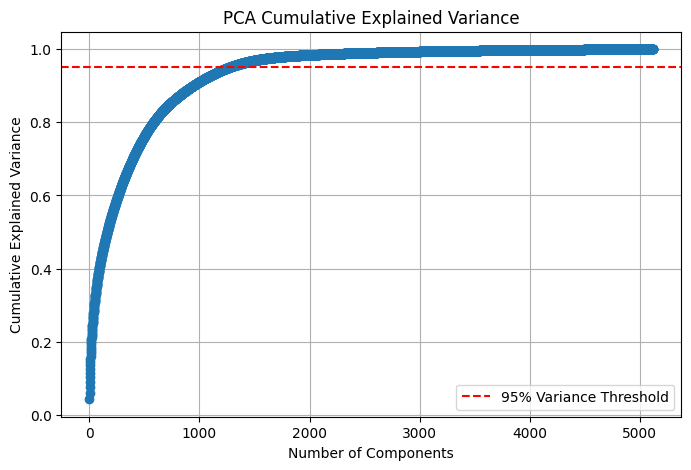

In [17]:
import matplotlib.pyplot as plt

data = combined_features.copy()

# Drop non-feature columns
features = data.drop(columns=['image_name', 'image_id', 'label', 'disease_name'])

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Fit PCA to the standardized data
pca = PCA()
pca.fit(scaled_data)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 95% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {num_components}")

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('PCA Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Exclude the 'image_name' , 'disease_name' column and standardize features
feature_data = data.drop(columns=['image_name',
                                  'image_id',
                                  'label',
                                  'disease_name'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_data)

# Apply PCA
pca = PCA(n_components=num_components)
pca_features = pca.fit_transform(scaled_features)

# Save PCA-transformed features
pca_features_df = pd.DataFrame(pca_features, columns=[f'pca_{i}' for i in range(pca.n_components_)])
pca_features_df['image_name'] = data['image_name']
pca_features_df['disease_name'] = data['disease_name']
pca_features_df['image_id'] = data['image_id']
pca_features_df['label'] = data['label']
pca_features_df.to_csv("pca_features_balanced.csv", index=False)
files.download("/content/pca_features_balanced.csv")
print("PCA features saved to 'pca_features_balanced.csv'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PCA features saved to 'pca_features_balanced.csv'


In [ ]:
files.download("/content/pca_features_balanced.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(f"Number of rows: {pca_features_df.shape[0]}, Number of columns: {pca_features_df.shape[1]}")

Number of rows: 17938, Number of columns: 134


In [ ]:
data['disease_name'].value_counts()

,count
disease_name,
Cassava Mosaic Disease (CMD),11027
Healthy,2166
Cassava Green Mottle (CGM),1993
Cassava Brown Streak Disease (CBSD),1831
Cassava Bacterial Blight (CBB),921


In [ ]:
pca_features_df['disease_name'].value_counts()

,count
disease_name,
Cassava Mosaic Disease (CMD),11027
Healthy,2166
Cassava Green Mottle (CGM),1993
Cassava Brown Streak Disease (CBSD),1831
Cassava Bacterial Blight (CBB),921


### Model Training

In [ ]:
X = data.drop(
    columns=['image_name', 'image_id', 'label', 'disease_name'])
y = data['disease_name']

#### Pre-defined functions

In [ ]:
def get_balanced_train_test_split(X, y):
  # Step 1: Identify the smallest class
  class_counts = y.value_counts()
  min_class_size = class_counts.min()

  # Step 2: Downsample each class to match the smallest class size
  balanced_X = []
  balanced_y = []

  for class_label in class_counts.index:
      class_X = X[y == class_label]
      class_y = y[y == class_label]

      # Randomly sample to match the size of the smallest class
      sampled_class_X = class_X.sample(n=min_class_size, random_state=42)
      sampled_class_y = class_y.sample(n=min_class_size, random_state=42)

      balanced_X.append(sampled_class_X)
      balanced_y.append(sampled_class_y)

  # Step 3: Concatenate the balanced data back together
  balanced_X = pd.concat(balanced_X, axis=0)
  balanced_y = pd.concat(balanced_y, axis=0)

  # Step 4: Split into train and test sets with stratification
  X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y,
                                                      test_size=0.2,
                                                      stratify=balanced_y,
                                                      random_state=42)

  print(np.unique(balanced_y, return_counts=True))

  return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

def train_rf(X_train, y_train, X_test, y_test):

  # Define the objective function for Bayesian optimization
  def objective(params):
      # Create the Random Forest model with parameters
      clf = RandomForestClassifier(
          n_estimators=int(params["n_estimators"]),
          max_depth=int(params["max_depth"]),
          min_samples_split=int(params["min_samples_split"]),
          min_samples_leaf=int(params["min_samples_leaf"]),
          max_features=params["max_features"],
          class_weight='balanced',
          random_state=42,
      )
      # Train the model
      clf.fit(X_train, y_train)

      # Evaluate the model on the test set
      y_pred = clf.predict(X_test)
      accuracy = accuracy_score(y_test, y_pred)

      # Minimize -accuracy (hyperopt minimizes the objective function)
      return {"loss": -accuracy, "status": STATUS_OK}

  # Define the search space
  space = {
      "n_estimators": hp.quniform("n_estimators", 50, 300, 10),
      "max_depth": hp.quniform("max_depth", 5, 30, 1),
      "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
      "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 5, 1),
      "max_features": hp.choice("max_features", ["sqrt"]),
  }

  # Run Bayesian optimization
  trials = Trials()
  best_params = fmin(
      fn=objective,
      space=space,
      algo=tpe.suggest,
      max_evals=5,  # Number of iterations for optimization
      trials=trials,
      rstate=np.random.default_rng(42)  # Ensures reproducibility
  )

  # Best parameters
  print("Best Parameters:", best_params)

  # Train the final model with the best parameters
  final_clf = RandomForestClassifier(
      n_estimators=int(best_params["n_estimators"]),
      max_depth=int(best_params["max_depth"]),
      min_samples_split=int(best_params["min_samples_split"]),
      min_samples_leaf=int(best_params["min_samples_leaf"]),
      max_features=["sqrt"][best_params["max_features"]],
      class_weight='balanced',
      random_state=42,
  )
  final_clf.fit(X_train, y_train)

  # Evaluate the final model
  y_pred = final_clf.predict(X_test)
  print("Final Accuracy:", accuracy_score(y_test, y_pred))
  print("Classification Report:\n", classification_report(y_test, y_pred))
  return final_clf, y_pred

In [ ]:
def get_feat_importances(clf):
  feature_names = [f"feature {i}" for i in range(X.shape[1])]
  importances = clf.feature_importances_
  return pd.Series(importances, index=feature_names).sort_values()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred):
  # Compute confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

def plot_roc_auc(clf, X_test, y_test):
  # Assuming 'model' is your trained model, and 'X_test' and 'y_test' are your test data and labels
  n_classes = len(set(y_test))  # Number of unique classes

  unique_classes = sorted(set(y_test))
  print("Unique classes:", unique_classes)

  # Binarize the true labels for multi-class classification
  y_test_bin = label_binarize(y_test, classes=unique_classes)  # Adjust class labels accordingly
  y_score = clf.predict_proba(X_test)  # Model predictions for each class

  # Initialize the plot
  plt.figure(figsize=(8, 6))

  # Iterate over each class to compute the ROC curve
  for i in range(n_classes):
      fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc = auc(fpr, tpr)  # Calculate AUC for this class
      plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

  # Plot the random classifier line (diagonal)
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

  # Set plot labels and title
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-Class (One-vs-Rest)')
  plt.legend(loc='lower right')

  # Show the plot
  plt.show()

  # Optional: Compute and print the macro-average AUC score
  roc_auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
  print(f'Macro-average AUC: {roc_auc_macro:.2f}')

#### Balanced Model

In [ ]:
balanced_X_train, balanced_X_test, balanced_y_train, balanced_y_test = get_balanced_train_test_split(X=X, y=y)

balanced_final_clf, balanced_final_y_pred = train_rf(
    X_train=balanced_X_train,
    X_test=balanced_X_test,
    y_train=balanced_y_train,
    y_test=balanced_y_test
)

(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([921, 921, 921, 921, 921]))
100%|██████████| 5/5 [02:48<00:00, 33.65s/trial, best loss: -0.6742671009771987]
Best Parameters: {'max_depth': 21.0, 'max_features': 0, 'min_samples_leaf': 5.0, 'min_samples_split': 7.0, 'n_estimators': 250.0}
Final Accuracy: 0.6742671009771987
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.64      0.67      0.66       184
Cassava Brown Streak Disease (CBSD)       0.63      0.59      0.61       184
         Cassava Green Mottle (CGM)       0.72      0.64      0.67       184
       Cassava Mosaic Disease (CMD)       0.78      0.84      0.81       185
                            Healthy       0.60      0.63      0.62       184

                           accuracy      

In [ ]:
balanced_clf_importances = get_feat_importances(clf=balanced_final_clf)
balanced_clf_importances

,0
feature 4523,0.000009
feature 4197,0.000010
feature 1199,0.000012
feature 4689,0.000015
feature 2963,0.000018
...,...
feature 95,0.003625
feature 748,0.003960
feature 469,0.004641
feature 853,0.004816


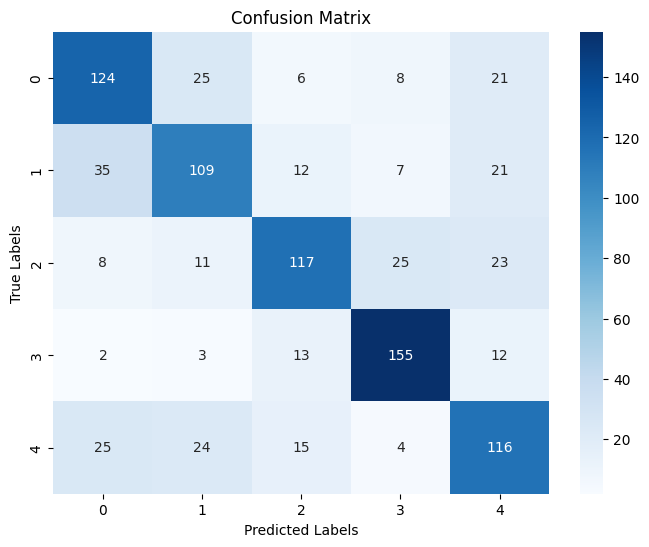

In [ ]:
plot_confusion_matrix(y_pred=balanced_final_y_pred, y_test=balanced_y_test)

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


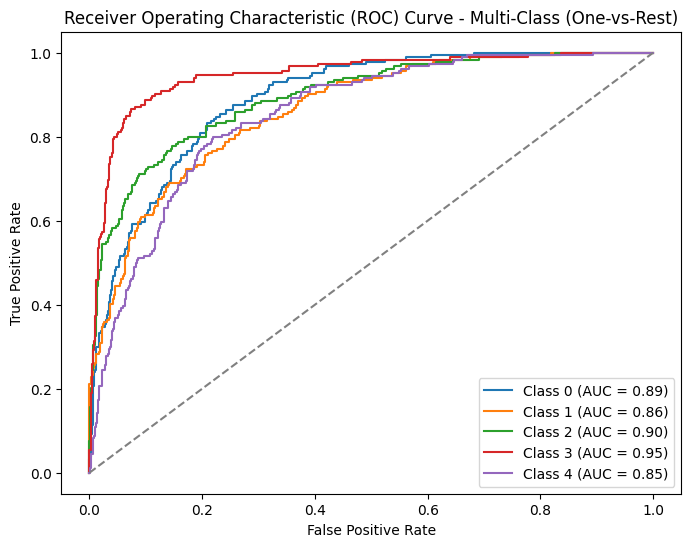

Macro-average AUC: 0.89


In [ ]:
plot_roc_auc(clf=balanced_final_clf, X_test=balanced_X_test, y_test=balanced_y_test)

#### Unbalanced model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
unbalanced_final_clf, unbalanced_final_y_pred = train_rf(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

100%|██████████| 5/5 [14:02<00:00, 168.41s/trial, best loss: -0.7689520624303233]
Best Parameters: {'max_depth': 21.0, 'max_features': 0, 'min_samples_leaf': 5.0, 'min_samples_split': 7.0, 'n_estimators': 250.0}
Final Accuracy: 0.7689520624303233
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.49      0.44      0.46       184
Cassava Brown Streak Disease (CBSD)       0.59      0.49      0.53       366
         Cassava Green Mottle (CGM)       0.78      0.30      0.43       399
       Cassava Mosaic Disease (CMD)       0.84      0.97      0.90      2206
                            Healthy       0.56      0.55      0.55       433

                           accuracy                           0.77      3588
                          macro avg       0.65      0.55      0.58      3588
                       weighted avg       0.76      0.77      0.75      3588



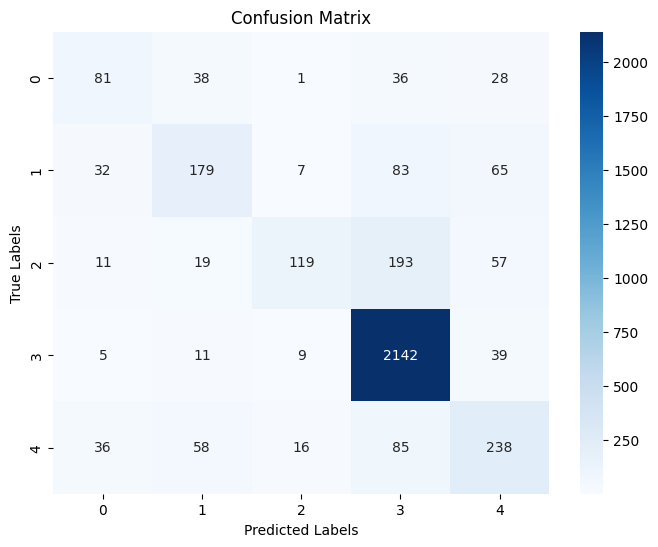

In [ ]:
plot_confusion_matrix(y_pred=unbalanced_final_y_pred, y_test=y_test)

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


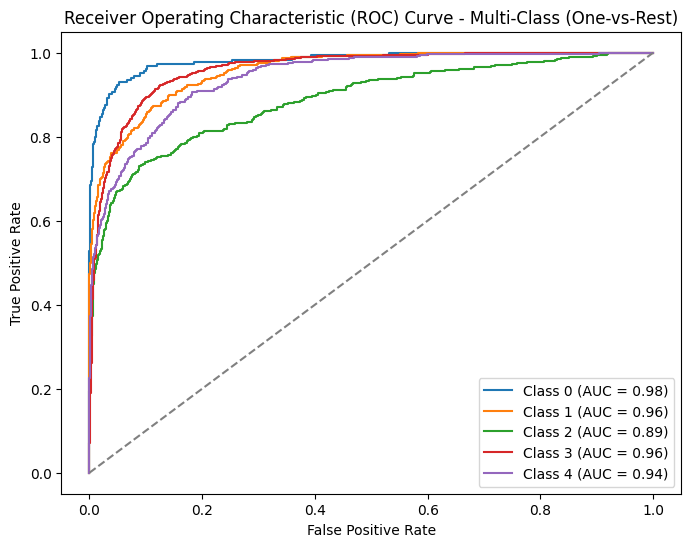

Macro-average AUC: 0.95


In [ ]:
plot_roc_auc(clf=unbalanced_final_clf, X_test=X_test, y_test=y_test)

#### Reduced Dimensionality Balanced Model

In [ ]:
pca_X = pca_features_df.drop(
    columns=['image_name', 'image_id', 'label', 'disease_name'])
pca_y = pca_features_df['disease_name']

pca_balanced_X_train, pca_balanced_X_test, pca_balanced_y_train, pca_balanced_y_test = get_balanced_train_test_split(
    X=pca_X, y=pca_y)

pca_balanced_final_clf, pca_balanced_final_y_pred = train_rf(
    X_train=pca_balanced_X_train,
    X_test=pca_balanced_X_test,
    y_train=pca_balanced_y_train,
    y_test=pca_balanced_y_test
)

(array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object), array([921, 921, 921, 921, 921]))
100%|██████████| 5/5 [00:29<00:00,  5.81s/trial, best loss: -0.5689467969598263]
Best Parameters: {'max_depth': 21.0, 'max_features': 0, 'min_samples_leaf': 5.0, 'min_samples_split': 7.0, 'n_estimators': 250.0}
Final Accuracy: 0.5689467969598263
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.51      0.54      0.52       184
Cassava Brown Streak Disease (CBSD)       0.53      0.41      0.46       184
         Cassava Green Mottle (CGM)       0.64      0.52      0.57       184
       Cassava Mosaic Disease (CMD)       0.68      0.77      0.72       185
                            Healthy       0.50      0.60      0.55       184

                           accuracy      

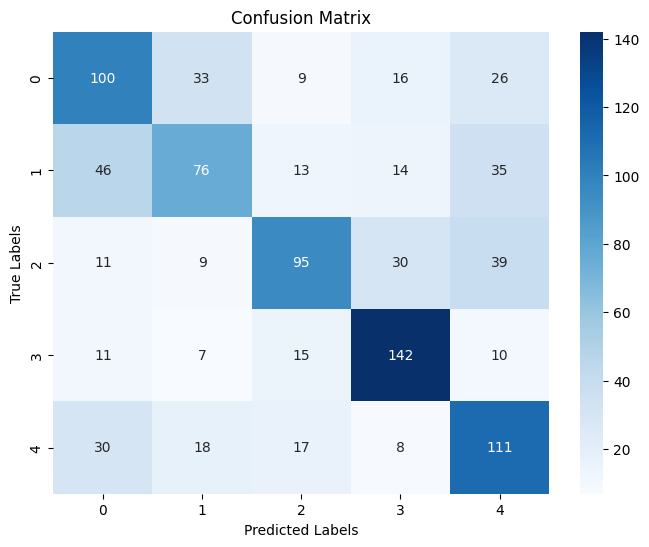

In [ ]:
plot_confusion_matrix(y_pred=pca_balanced_final_y_pred,
                      y_test=pca_balanced_y_test)

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


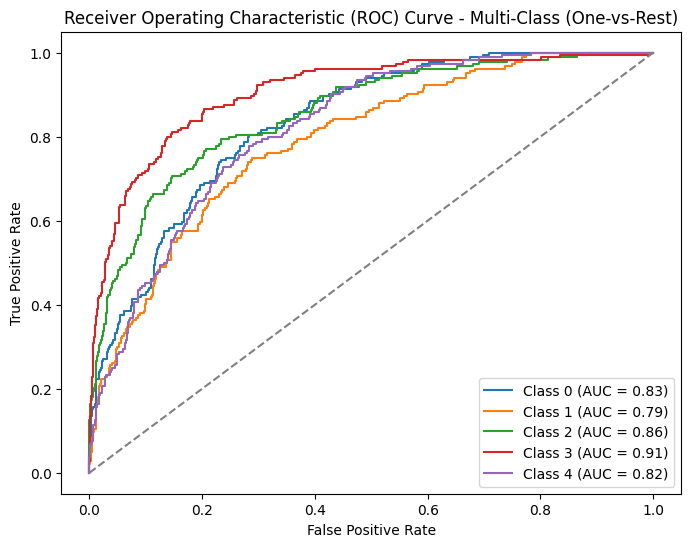

Macro-average AUC: 0.84


In [ ]:
plot_roc_auc(clf=pca_balanced_final_clf,
             X_test=pca_balanced_X_test,
             y_test=pca_balanced_y_test)

#### Reduced Dimensionality Unbalanced Model

In [ ]:
pca_unbalanced_X_train, pca_unbalanced_X_test, pca_unbalanced_y_train, pca_unbalanced_y_test = train_test_split(
    pca_X, pca_y,
    test_size=0.2,
    stratify=pca_y,
    random_state=42)

pca_unbalanced_final_clf, pca_unbalanced_final_y_pred = train_rf(
    X_train=pca_unbalanced_X_train,
    X_test=pca_unbalanced_X_test,
    y_train=pca_unbalanced_y_train,
    y_test=pca_unbalanced_y_test
)

100%|██████████| 5/5 [02:19<00:00, 27.91s/trial, best loss: -0.7129319955406912]
Best Parameters: {'max_depth': 21.0, 'max_features': 0, 'min_samples_leaf': 5.0, 'min_samples_split': 7.0, 'n_estimators': 250.0}
Final Accuracy: 0.7129319955406912
Classification Report:
                                      precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.44      0.26      0.32       184
Cassava Brown Streak Disease (CBSD)       0.46      0.33      0.38       366
         Cassava Green Mottle (CGM)       0.58      0.16      0.25       399
       Cassava Mosaic Disease (CMD)       0.79      0.96      0.87      2206
                            Healthy       0.50      0.49      0.50       433

                           accuracy                           0.71      3588
                          macro avg       0.55      0.44      0.46      3588
                       weighted avg       0.68      0.71      0.67      3588



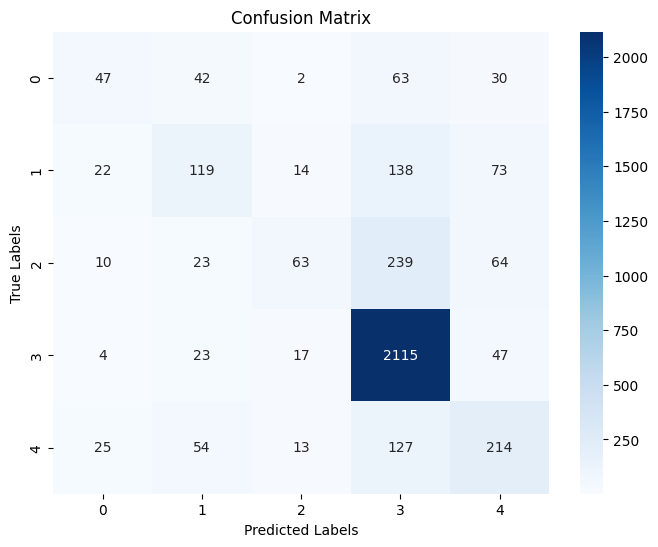

In [ ]:
plot_confusion_matrix(y_pred=pca_unbalanced_final_y_pred,
                      y_test=pca_unbalanced_y_test)

Unique classes: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


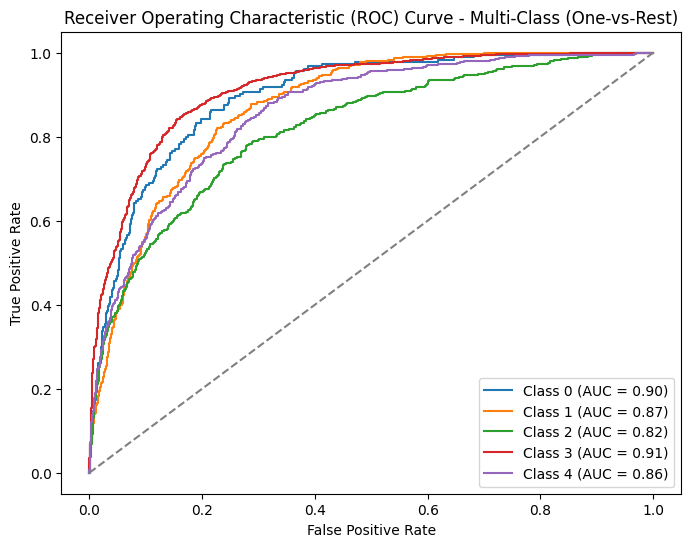

Macro-average AUC: 0.87


In [ ]:
plot_roc_auc(clf=pca_unbalanced_final_clf,
             X_test=pca_unbalanced_X_test,
             y_test=pca_unbalanced_y_test)

### Model Evaluation

#### Pre-defined functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


def plot_pca_2d(X, y):

  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform PCA
  pca = PCA(n_components=2)  # Reduce to 2 components for 2D visualization
  reduced_features = pca.fit_transform(X)

  # Plot the PCA results
  plt.figure(figsize=(8, 6))

  # Scatter plot with coloring based on encoded class labels
  scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  plt.colorbar(scatter, label="Class")

  # Add titles and labels
  plt.title("PCA Visualization of Feature Space")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")

  # Display grid
  plt.grid(True)

  # Show the plot
  plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

def plot_tsne_2d(X, y):
  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform t-SNE
  tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2 components for 2D visualization
  reduced_features_tsne = tsne.fit_transform(X)

  # Plot the t-SNE results
  plt.figure(figsize=(8, 6))

  # Scatter plot with coloring based on encoded class labels
  scatter_tsne = plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  plt.colorbar(scatter_tsne, label="Class")

  # Add titles and labels
  plt.title("t-SNE Visualization of Feature Space")
  plt.xlabel("t-SNE Component 1")
  plt.ylabel("t-SNE Component 2")

  # Display grid
  plt.grid(True)

  # Show the plot
  plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

def plot_pca_3d(X, y):
  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform PCA (3 components for 3D)
  pca = PCA(n_components=3)
  reduced_features_pca = pca.fit_transform(X)

  # Plot the 3D PCA results
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot with coloring based on encoded class labels
  scatter_pca = ax.scatter(reduced_features_pca[:, 0], reduced_features_pca[:, 1], reduced_features_pca[:, 2],
                          c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  fig.colorbar(scatter_pca, ax=ax, label="Class")

  # Add titles and labels
  ax.set_title("3D PCA Visualization of Feature Space")
  ax.set_xlabel("PCA Component 1")
  ax.set_ylabel("PCA Component 2")
  ax.set_zlabel("PCA Component 3")

  # Show the plot
  plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

def plot_tsne_3d(X, y):

  # Assuming X is your feature matrix and y is your target labels (e.g., string labels)

  # Encode class labels as numbers
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  # Perform t-SNE (3 components for 3D)
  tsne = TSNE(n_components=3, random_state=42)
  reduced_features_tsne = tsne.fit_transform(X)

  # Plot the 3D t-SNE results
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot with coloring based on encoded class labels
  scatter_tsne = ax.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], reduced_features_tsne[:, 2],
                            c=y_encoded, cmap="viridis", alpha=0.8)

  # Add colorbar to indicate the class labels
  fig.colorbar(scatter_tsne, ax=ax, label="Class")

  # Add titles and labels
  ax.set_title("3D t-SNE Visualization of Feature Space")
  ax.set_xlabel("t-SNE Component 1")
  ax.set_ylabel("t-SNE Component 2")
  ax.set_zlabel("t-SNE Component 3")

  # Show the plot
  plt.show()

#### Balanced Model

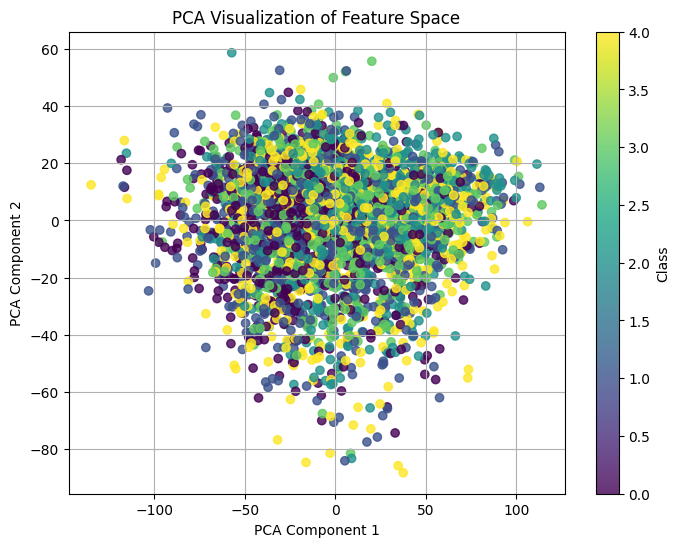

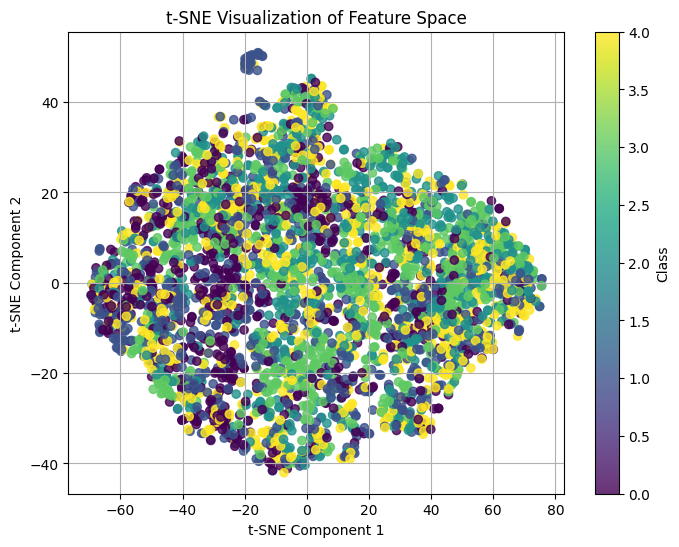

In [ ]:
# Balanced plotting
plot_pca_2d(X=balanced_X_train, y=balanced_y_train)
plot_tsne_2d(X=balanced_X_train, y=balanced_y_train)
#plot_pca_3d(X=balanced_X_train, y=balanced_y_train)
#plot_tsne_3d(X=balanced_X_train, y=balanced_y_train)

#### Unbalanced Model

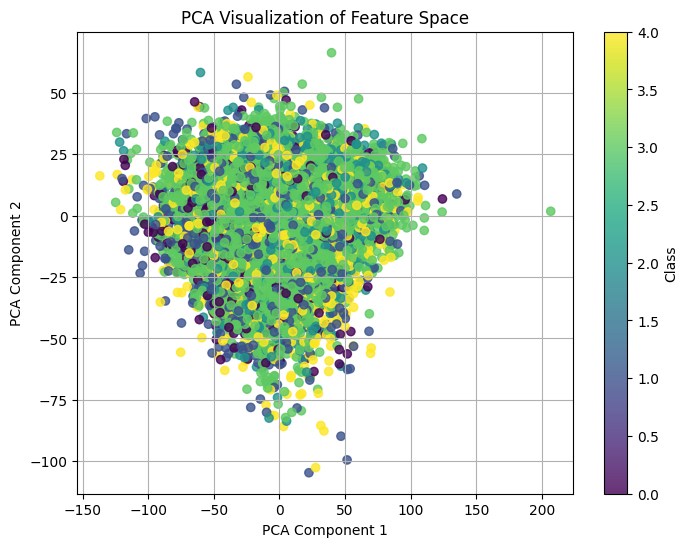

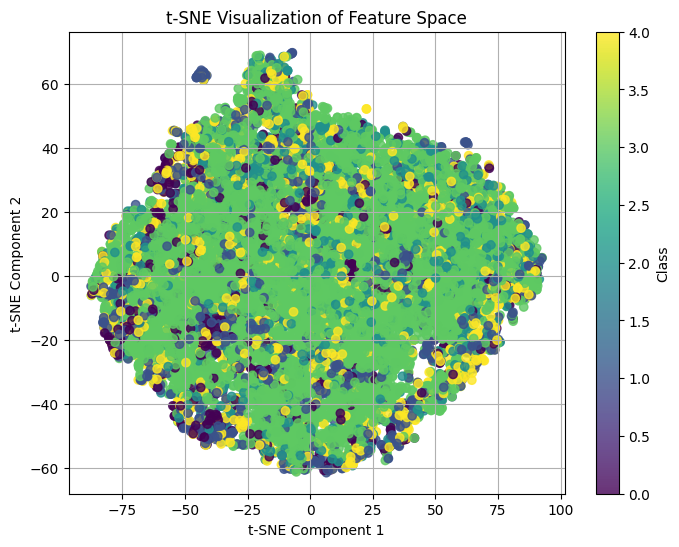

In [ ]:
# Unbalanced plotting
plot_pca_2d(X=X_train, y=y_train)
plot_tsne_2d(X=X_train, y=y_train)
#plot_pca_3d(X=X, y=y)
#plot_tsne_3d(X=X, y=y)

#### Balanced PCA Model

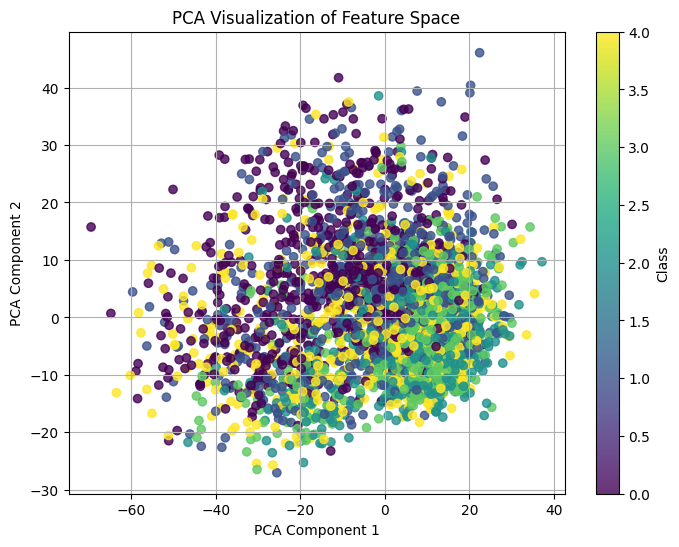

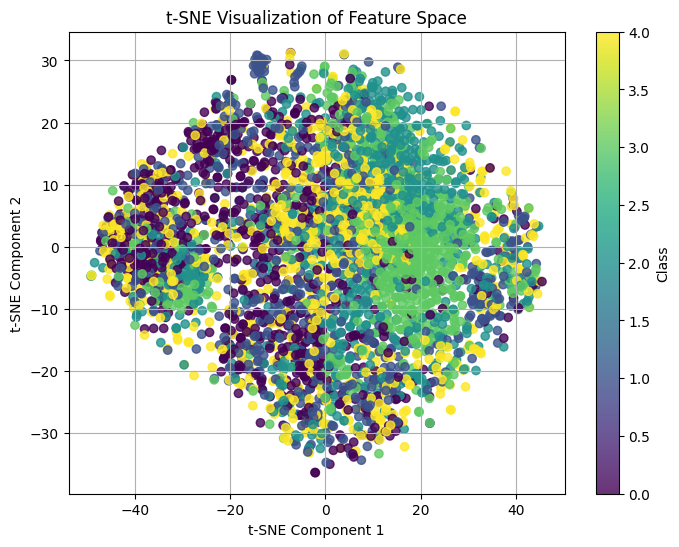

In [ ]:
# balanced PCA plotting
plot_pca_2d(X=pca_balanced_X_train, y=pca_balanced_y_train)
plot_tsne_2d(X=pca_balanced_X_train, y=pca_balanced_y_train)
#plot_pca_3d(X=X, y=y)
#plot_tsne_3d(X=X, y=y)

#### Unbalanced PCA Model

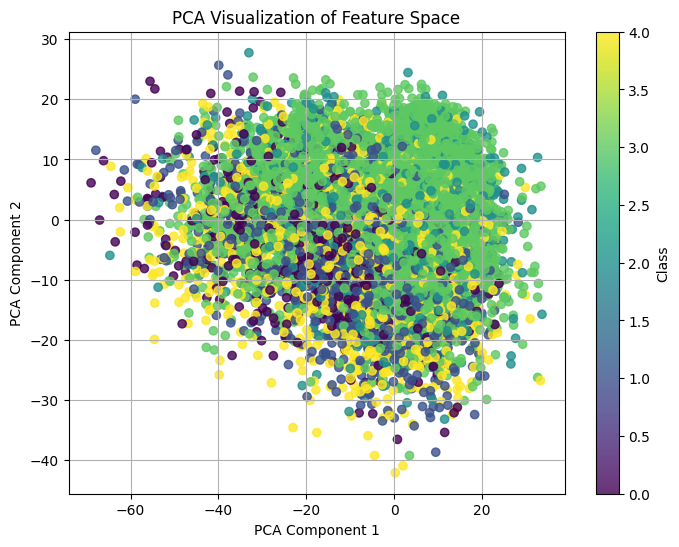

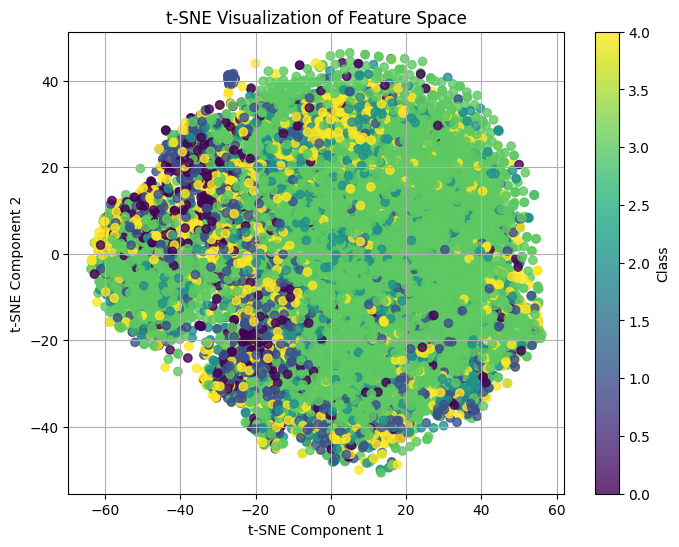

In [ ]:
# unbalanced PCA plotting
plot_pca_2d(X=pca_unbalanced_X_train, y=pca_unbalanced_y_train)
plot_tsne_2d(X=pca_unbalanced_X_train, y=pca_unbalanced_y_train)
#plot_pca_3d(X=X, y=y)
#plot_tsne_3d(X=X, y=y)